In [ ]:
!conda install -y -c conda-forge bottleneck

In [1]:
# Add submodule paths
import sys
sys.path += ['./normalizing_flows', './baselines', './climdex']

In [2]:
import tensorflow as tf
import tensorflow_probability as tfp
import matplotlib.pyplot as plt
import numpy as np
import utils.data as data_util
import utils.nn_util as nn
import xarray as xr
import gcsfs
import dscnn
from normalizing_flows.models.variational import parameterize, nll_loss, VariationalModel
from normalizing_flows.models.optimization import LinearWarmupSchedule
from normalizing_flows.flows import Invert
from normalizing_flows.flows.glow import GlowFlow, coupling_nn_glow
from datasource import EraiRasDataLoader
from utils.pipeline_v2 import Pipeline, fillnan, clip, remove_monthly_means
from utils.distributions import normal
from tensorflow.keras.optimizers import Adamax
#tf.debugging.set_log_device_placement(True)

In [3]:
data = EraiRasDataLoader(gcs_bucket='erai-rasmussen', gcs_project='thesis-research-255223', auth='gcs.secret.json')
# era-interim
erai_deg1 = xr.open_zarr(data.erai('daily-1deg'), consolidated=True)
# 1-degree regridded rasmussen
ras_deg1 = xr.open_zarr(data.rasmussen('daily-1deg'), consolidated=True)
# 1/2-degree regridded rasmussen
ras_deg12 = xr.open_zarr(data.rasmussen('daily-1-2deg'), consolidated=True)
ras_deg14 = xr.open_zarr(data.rasmussen('daily-1-4deg'), consolidated=True)
ras_deg18 = xr.open_zarr(data.rasmussen('daily-1-8deg'), consolidated=True)
#ras_deg116 = xr.open_zarr(rasmussen('daily-1-16deg'), consolidated=True)
# regions
def southeast_us(dataset, scale_factor=1):
    lats, lons = dataset.lat, dataset.lon
    seus_lat_st = np.abs(lats - 30).argmin().values
    seus_lat_en = seus_lat_st + 16*scale_factor
    seus_lon_st = np.abs(lons - 260).argmin().values
    seus_lon_en = seus_lon_st + 32*scale_factor
    dataset_seus = dataset.isel(lat=slice(seus_lat_st, seus_lat_en),
                                lon=slice(seus_lon_st, seus_lon_en))
    return dataset_seus

erai_deg1_seus = southeast_us(erai_deg1)
ras_deg1_seus = southeast_us(ras_deg1)
ras_deg12_seus = southeast_us(ras_deg12, scale_factor=2)
ras_deg14_seus = southeast_us(ras_deg14, scale_factor=4)
ras_deg18_seus = southeast_us(ras_deg18, scale_factor=8)

In [4]:
split_fn = data_util.create_time_series_train_test_generator(n_splits=3)
preprocess_maxt = Pipeline('MAXT', fillnan(0), clip(0), remove_monthly_means())
preprocess_hgt = Pipeline('HGT', fillnan(0), clip(0))
ras_seus_maxt_14 = preprocess_maxt(ras_deg14_seus)
ras_seus_maxt_1 = preprocess_maxt(ras_deg1_seus)
folds = list(split_fn(ras_seus_maxt_1, ras_seus_maxt_14))

In [5]:
def preprocess_vds(data_lo, data_hi, scale=2, n_epochs=1, batch_size=100, buffer_size=1000):
    data = tf.data.Dataset.zip((data_lo, data_hi)).shuffle(buffer_size)
    batch = data.batch(batch_size)
    return batch.repeat(n_epochs)

def preprocess_vae(data, scale=2, n_epochs=1, batch_size=100, buffer_size=1000):
    batch = data.shuffle(buffer_size).batch(batch_size)
    return batch.repeat(n_epochs)

def simple_inference_net(c_in, c_out, kernel_size=(3,3)):
    from tensorflow.keras import Model
    from tensorflow.keras.layers import Input, Conv2D
    from normalizing_flows.layers import ActNorm
    x = Input((None, None, c_in))
    y = Conv2D(c_out, kernel_size, padding='same', kernel_initializer='zeros')(x)
    #y = ActNorm()(y)
    return Model(inputs=x, outputs=y)

In [ ]:
sample_batch_size = 10
load_batch_size = 1200
n_epochs = 20
for i, ((train_lo, train_hi), (test_lo, test_hi)) in enumerate(folds):
    print(f'Fold {i+1}/{len(folds)}')
    N_train, N_test = train_lo.Time.size, train_lo.Time.size
    (wt, ht), (wt_hi, ht_hi) = train_lo.shape[1:3], train_hi.shape[1:3]
    print('{} training samples, {} test samples, {}x{} -> {}x{}'.format(N_train, N_test, wt, ht, wt_hi, ht_hi))
    #batch_multiplier = data_util.calculate_n_subimages(train_lo, k, stride)
    train_steps = data_util.num_batches(N_train, sample_batch_size)
    test_steps = data_util.num_batches(N_test, sample_batch_size)
    train_lo_ds = data_util.xr_to_tf_dataset(train_lo, load_batch_size)
    test_lo_ds = data_util.xr_to_tf_dataset(test_lo, load_batch_size)
    train_hi_ds = data_util.xr_to_tf_dataset(train_hi, load_batch_size)
    test_hi_ds = data_util.xr_to_tf_dataset(test_hi, load_batch_size)
    train_ds = preprocess_vds(train_lo_ds, train_hi_ds, n_epochs=n_epochs, batch_size=sample_batch_size)
    test_ds = preprocess_vds(test_lo_ds, test_hi_ds, n_epochs=n_epochs, batch_size=sample_batch_size)
    vdsrcnn = dscnn.create_vdsrcnn(scale=wt_hi // wt, c_in=1, c_out=2, module_layers=2, n_layers=5, output_init='zeros')
    normal_fn = normal()
    #vdsrcnn = dscnn.create_bmg_cnn10(wt, ht, scale=wt_hi // wt, c_out=2)
    vdsrcnn = parameterize(vdsrcnn, normal_fn)
    vdsrcnn.compile(loss=nll_loss(normal_fn), optimizer=Adamax(lr=1.0E-3))
    vdsrcnn.fit(train_ds, epochs=n_epochs, steps_per_epoch=train_steps,
                validation_data=test_ds, validation_steps=test_steps)
    pred = vdsrcnn.predict_mean(test_lo_ds.batch(1))
    sample = vdsrcnn.sample(test_lo_ds.batch(1))
    plt.figure(figsize=(4*8,6))
    plt.subplot(1,4,1)
    plt.imshow(next(test_ds.__iter__())[0].numpy()[0].squeeze())
    plt.subplot(1,4,2)
    plt.imshow(next(test_ds.__iter__())[1].numpy()[0].squeeze())
    plt.subplot(1,4,3)
    plt.imshow(pred[0].numpy().squeeze())
    plt.subplot(1,4,4)
    plt.imshow(sample[0].numpy().squeeze())
    plt.show()

Fold 1/3
1200 training samples, 1200 test samples, 16x32 -> 64x128


100%|██████████| 120/120 [00:15<00:00,  7.66it/s, nll=1.44, prior=1.35]


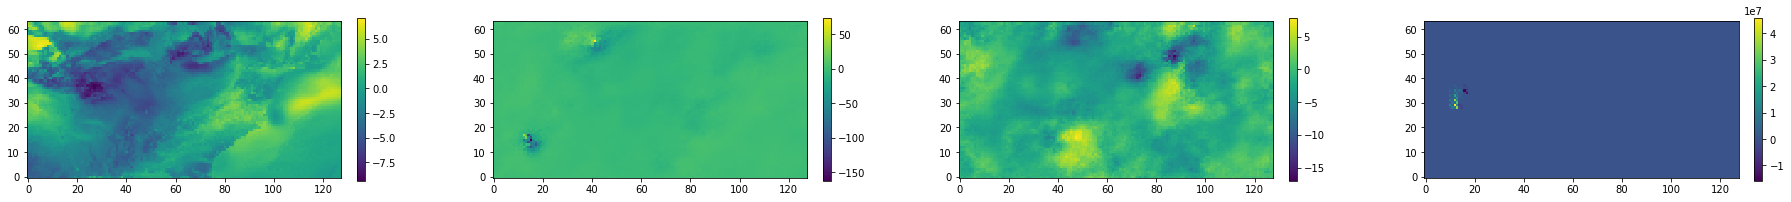

100%|██████████| 120/120 [00:14<00:00,  8.30it/s, nll=1.33, prior=1.38]


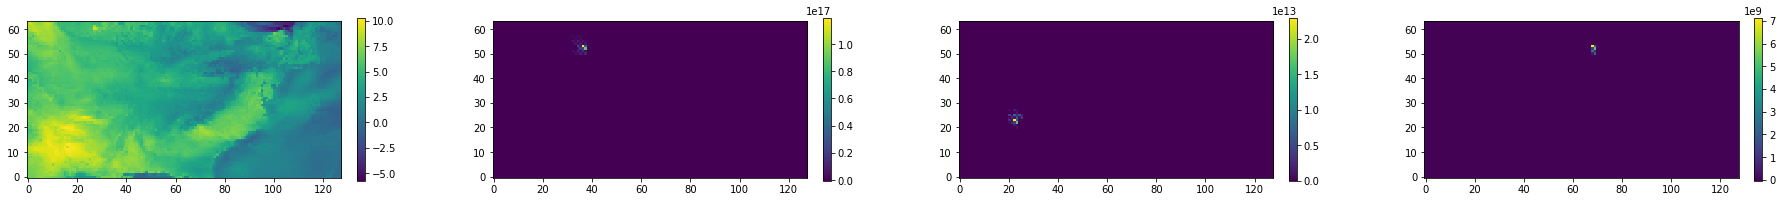

100%|██████████| 120/120 [00:13<00:00,  8.64it/s, nll=1.29, prior=1.31]


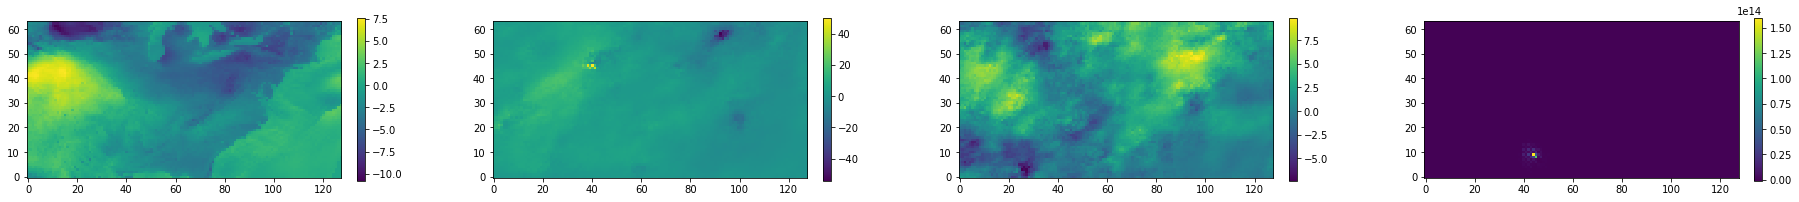

100%|██████████| 120/120 [00:14<00:00,  8.32it/s, nll=1.26, prior=1.31]


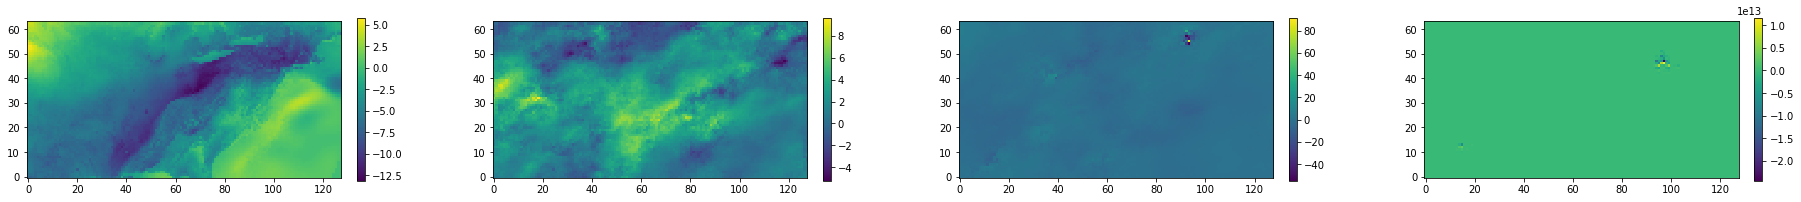

100%|██████████| 120/120 [00:13<00:00,  8.73it/s, nll=1.25, prior=1.34]


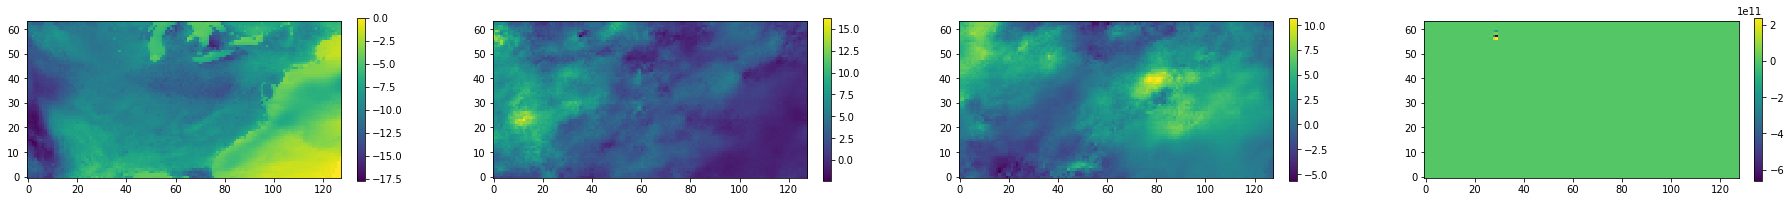

100%|██████████| 120/120 [00:14<00:00,  8.45it/s, nll=1.2, prior=1.34]


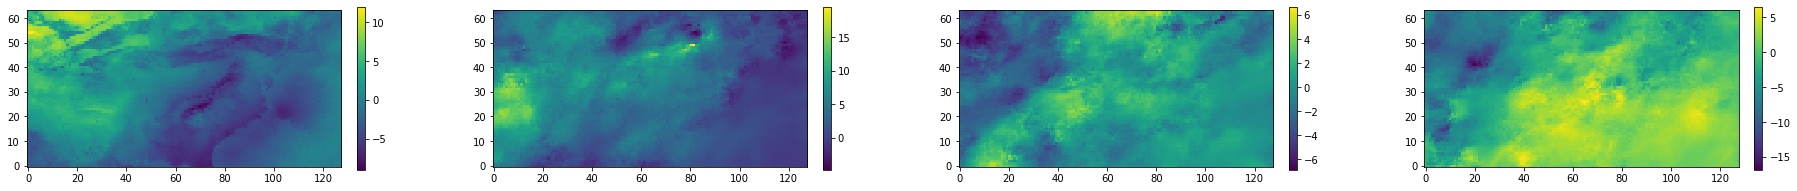

100%|██████████| 120/120 [00:13<00:00,  8.65it/s, nll=1.18, prior=1.31]


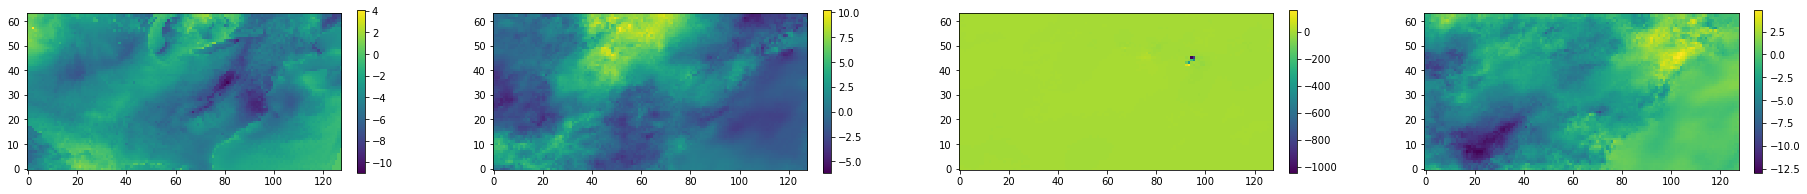

100%|██████████| 120/120 [00:14<00:00,  8.29it/s, nll=1.18, prior=1.29]


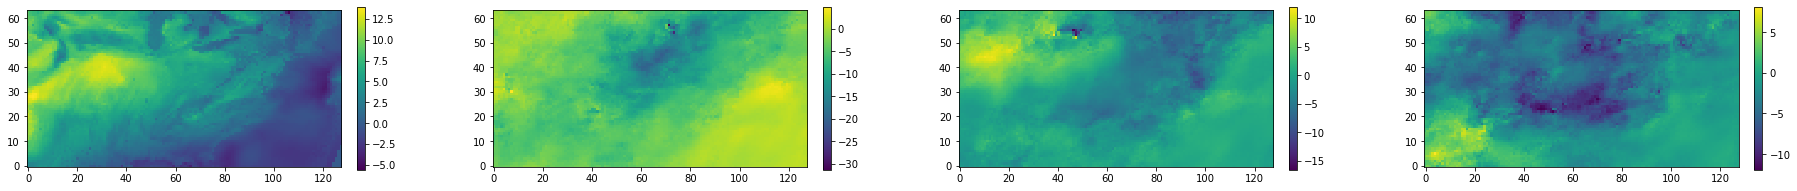

100%|██████████| 120/120 [00:13<00:00,  8.75it/s, nll=1.18, prior=1.32]


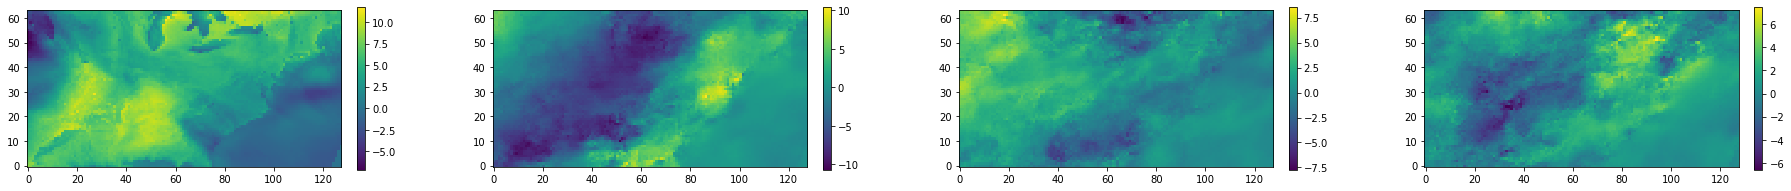

100%|██████████| 120/120 [00:13<00:00,  8.57it/s, nll=1.17, prior=1.25]


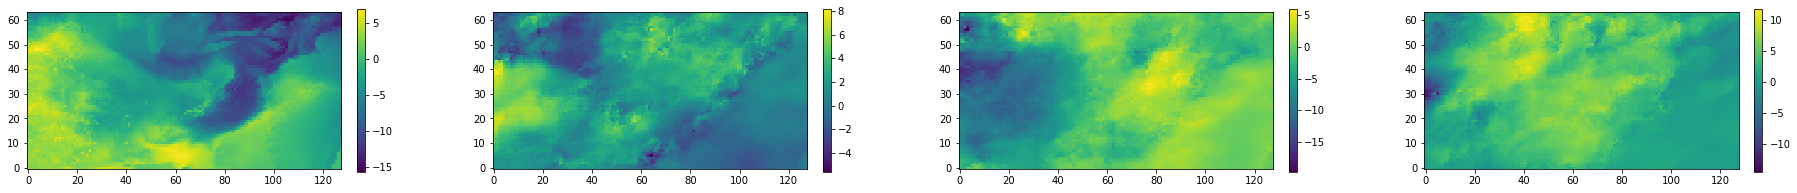

100%|██████████| 120/120 [00:13<00:00,  9.02it/s, nll=1.15, prior=1.28]


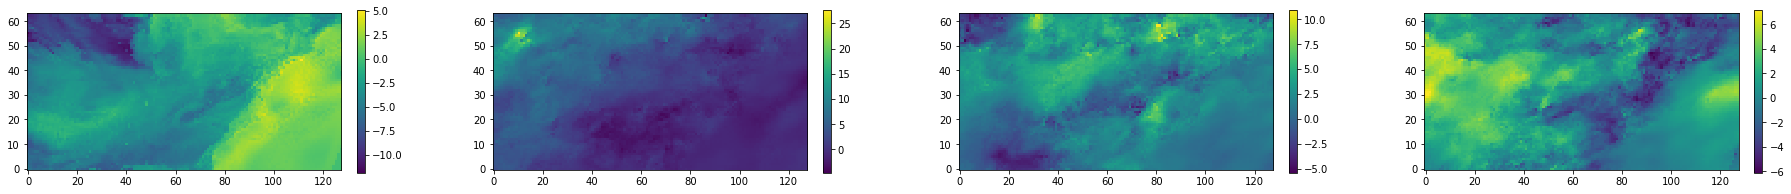

100%|██████████| 120/120 [00:14<00:00,  8.52it/s, nll=1.14, prior=1.31]


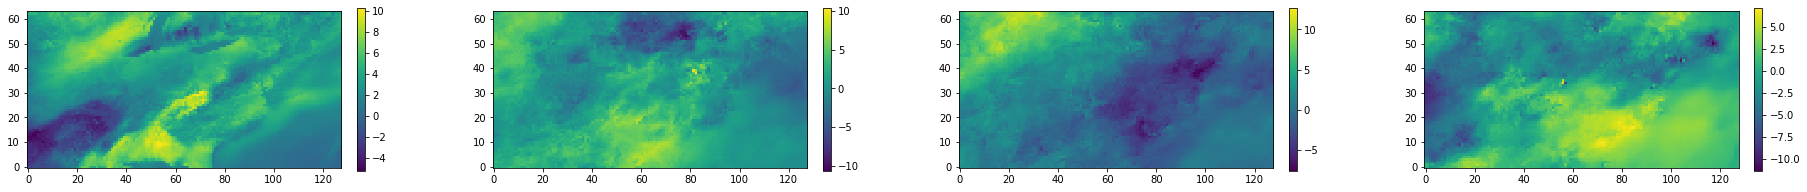

100%|██████████| 120/120 [00:14<00:00,  8.56it/s, nll=1.15, prior=1.42]


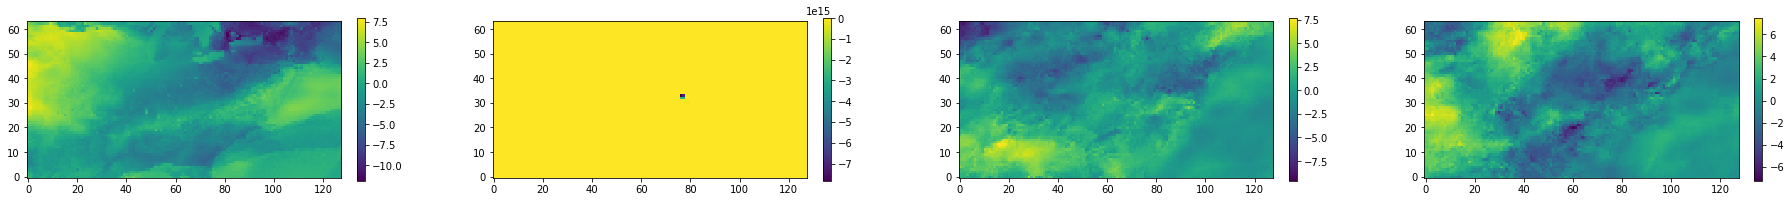

100%|██████████| 120/120 [00:14<00:00,  8.54it/s, nll=1.17, prior=1.29]


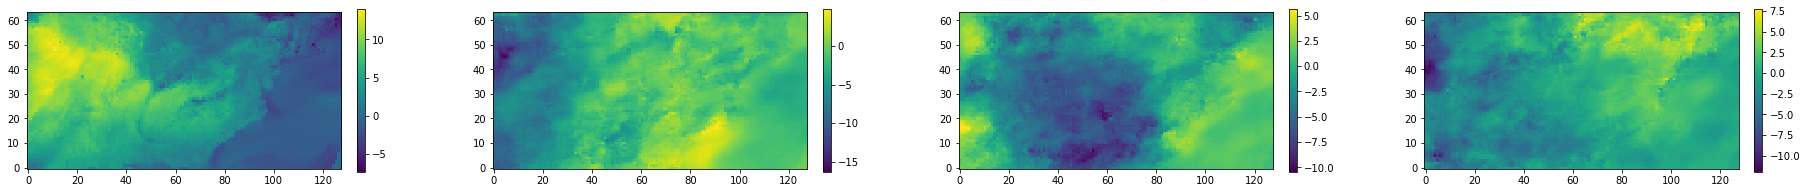

100%|██████████| 120/120 [00:14<00:00,  8.41it/s, nll=1.14, prior=1.32]


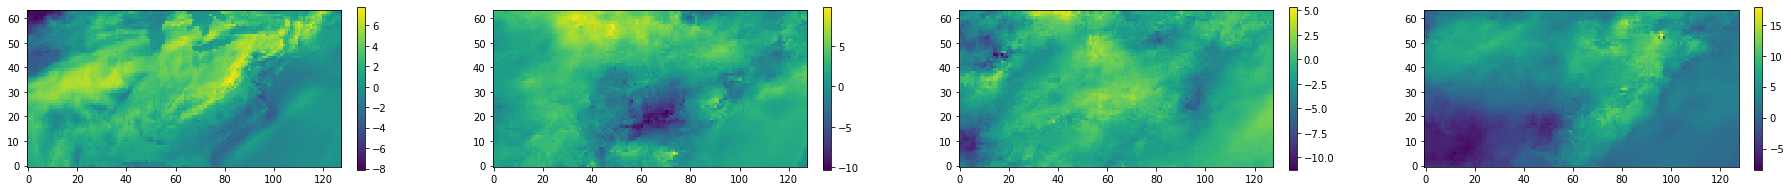

100%|██████████| 120/120 [00:14<00:00,  8.23it/s, nll=1.15, prior=1.38]


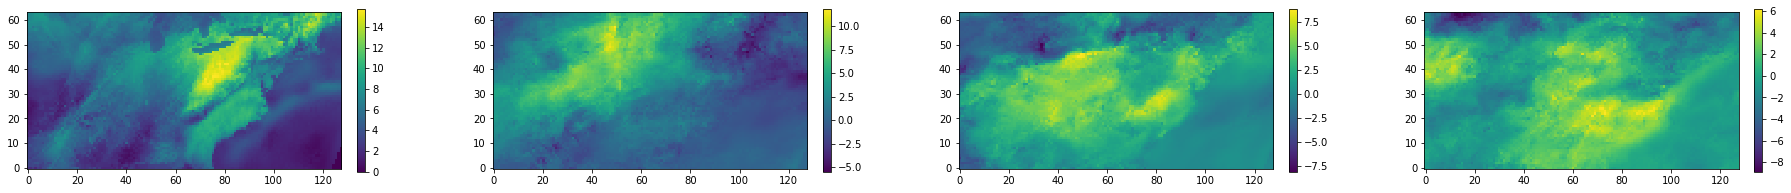

100%|██████████| 120/120 [00:13<00:00,  8.59it/s, nll=1.13, prior=1.4]


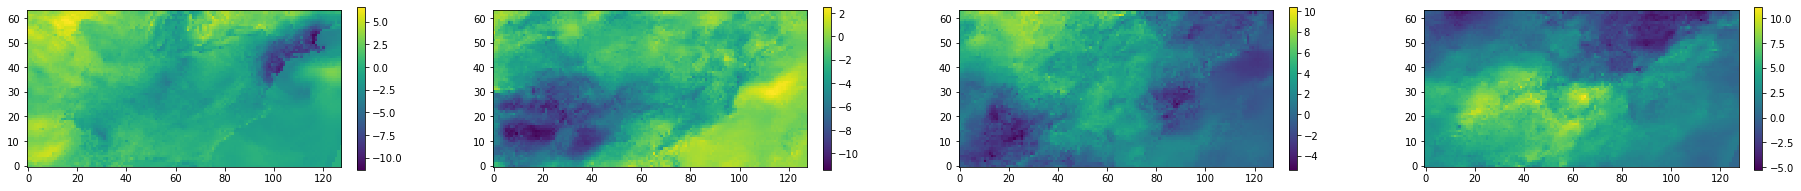

100%|██████████| 120/120 [00:14<00:00,  8.51it/s, nll=1.13, prior=1.37]


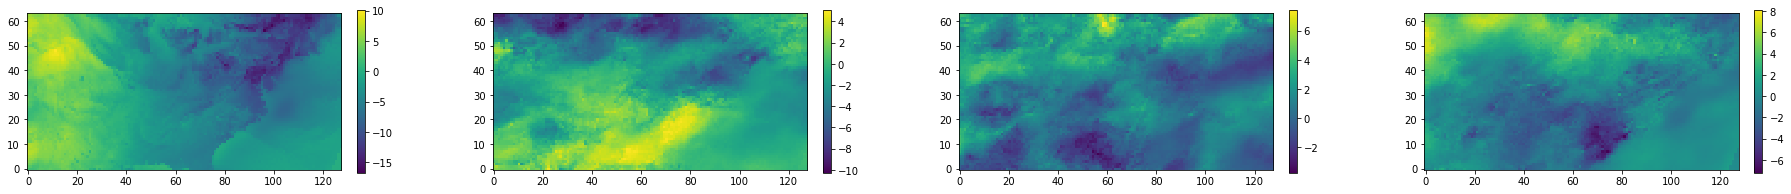

100%|██████████| 120/120 [00:14<00:00,  8.21it/s, nll=1.13, prior=1.41]


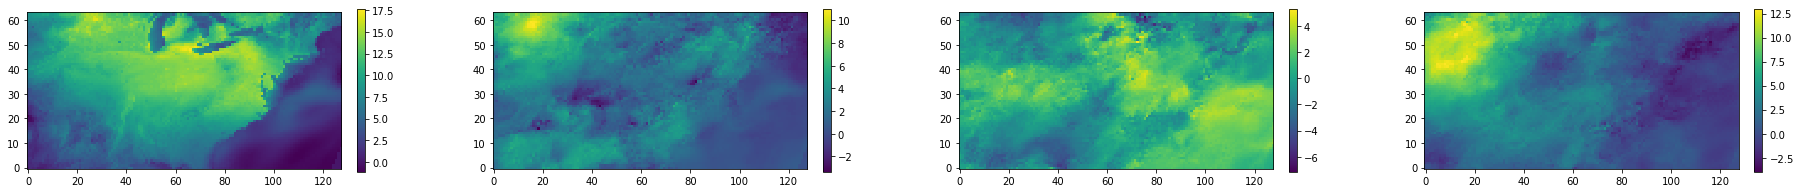

100%|██████████| 120/120 [00:14<00:00,  8.32it/s, nll=1.13, prior=1.35]


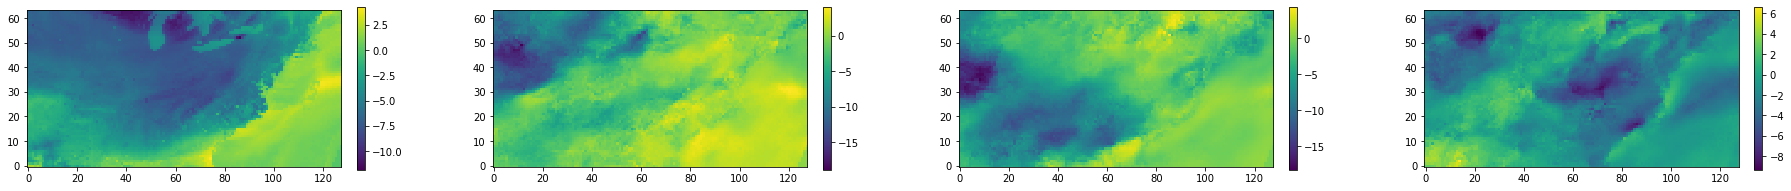

Fold 2/3
2400 training samples, 2400 test samples, 16x32 -> 64x128


100%|██████████| 240/240 [00:34<00:00,  7.05it/s, nll=1.33, prior=1.36]


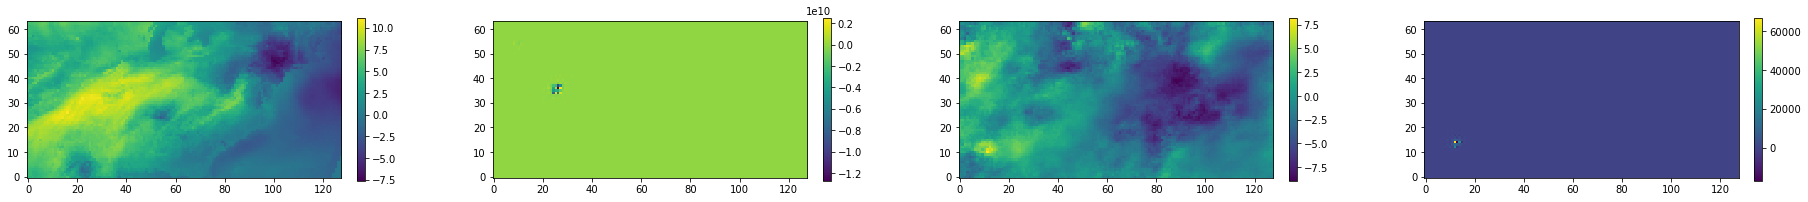

100%|██████████| 240/240 [00:31<00:00,  7.51it/s, nll=1.26, prior=1.34]


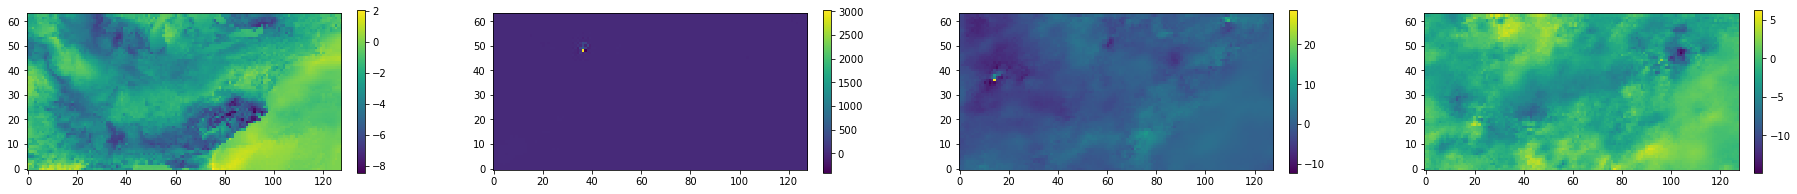

100%|██████████| 240/240 [00:33<00:00,  7.11it/s, nll=1.23, prior=1.3]


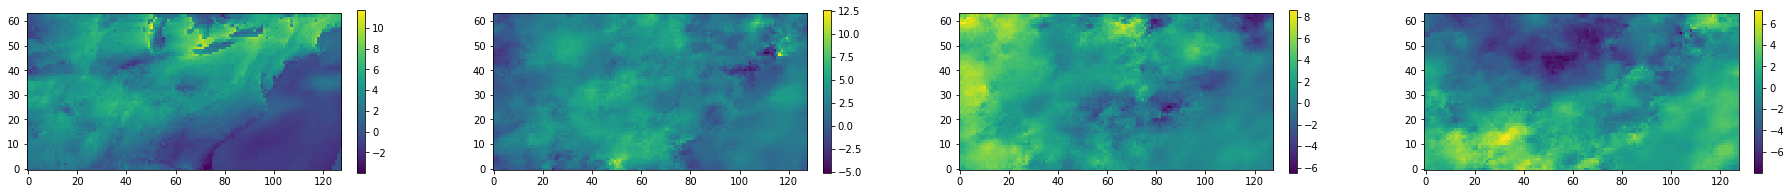

100%|██████████| 240/240 [00:33<00:00,  7.12it/s, nll=1.2, prior=1.31] 


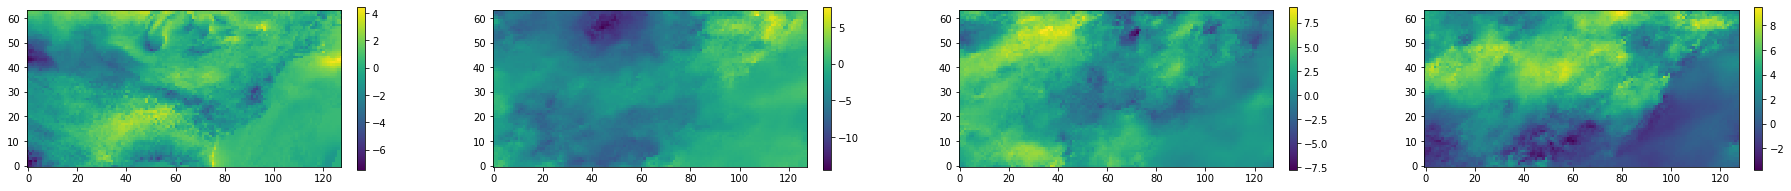

100%|██████████| 240/240 [00:32<00:00,  7.33it/s, nll=1.17, prior=1.31]


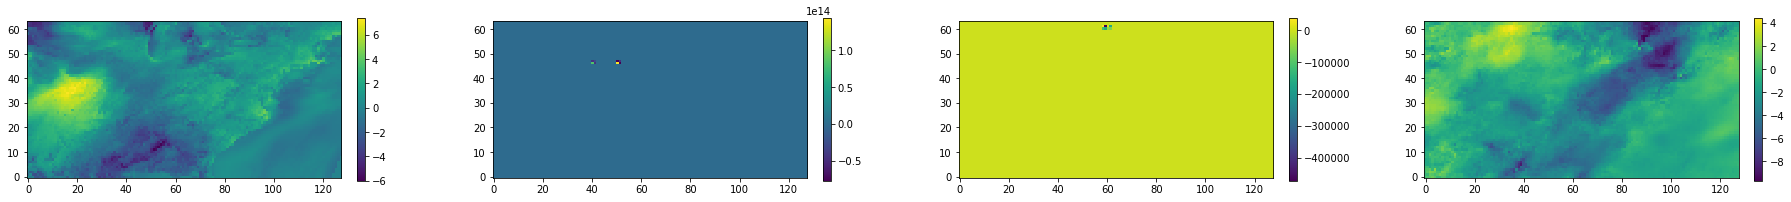

 40%|████      | 480/1200 [01:41<01:47,  6.73it/s, epoch=2, loss=1.16, nll=1.14, prior=1.29]  

In [ ]:
sample_batch_size = 10
load_batch_size = 1200
n_epochs = 100
validate_freq = 5
warmup_epochs = 10
models = []
for i, ((train_lo, train_hi), (test_lo, test_hi)) in enumerate(folds):
    print(f'Fold {i+1}/{len(folds)}')
    N_train, N_test = train_lo.Time.size, train_lo.Time.size
    (wt, ht), (wt_hi, ht_hi) = train_lo.shape[1:3], train_hi.shape[1:3]
    print('{} training samples, {} test samples, {}x{} -> {}x{}'.format(N_train, N_test, wt, ht, wt_hi, ht_hi))
    #batch_multiplier = data_util.calculate_n_subimages(train_lo, k, stride)
    train_steps = data_util.num_batches(N_train, sample_batch_size)
    test_steps = data_util.num_batches(N_test, sample_batch_size)
    train_lo_ds = data_util.xr_to_tf_dataset(train_lo, load_batch_size)
    test_lo_ds = data_util.xr_to_tf_dataset(test_lo, load_batch_size)
    train_hi_ds = data_util.xr_to_tf_dataset(train_hi, load_batch_size)
    test_hi_ds = data_util.xr_to_tf_dataset(test_hi, load_batch_size)
    train_ds = preprocess_vae(train_hi_ds, n_epochs=n_epochs, batch_size=sample_batch_size, buffer_size=N_train)
    test_ds = preprocess_vae(test_hi_ds, n_epochs=n_epochs, batch_size=sample_batch_size, buffer_size=N_test)
    #vdscnn = dscnn.create_vdsrcnn(scale=wt_hi//wt, c_in=1, c_out=2, n_layers=5, module_layers=2, output_init='zeros')
    #vdscnn = dscnn.create_bmg_cnn10(wt, ht, scale=4, c_out=2)
    vdscnn = simple_inference_net(c_in=1, c_out=2)
    vdscnn.trainable = False
    flow = Invert(GlowFlow(num_layers=4, depth=16, coupling_nn_ctor=coupling_nn_glow(hidden_dims=128)))
    learning_rate = LinearWarmupSchedule(1.0E-3, num_warmup_steps=N_train//sample_batch_size*warmup_epochs)
    #learning_rate = tf.keras.optimizers.schedules.InverseTimeDecay(1.0E-1, N_train//sample_batch_size, 0.1)
    model = VariationalModel(vdscnn, normal(), transform=flow, output_shape=(None,wt_hi,ht_hi,1),
                             optimizer=tf.keras.optimizers.Adamax(learning_rate=learning_rate))
    for i in range(0, n_epochs, validate_freq):
        model.train(train_ds, steps_per_epoch=N_train//sample_batch_size, num_epochs=validate_freq, supervised=False)
        model.evaluate(test_ds, N_test//sample_batch_size, supervised=False)
        sample = model.sample(n=3)
        plt.figure(figsize=(4*8,6))
        plt.subplot(1,4,1)
        plt.imshow(next(test_ds.__iter__()).numpy()[0].squeeze(), origin='lower')
        plt.colorbar(pad=0.04, shrink=0.5)
        plt.subplot(1,4,2)
        plt.imshow(sample[0].numpy().squeeze(), origin='lower')
        plt.colorbar(pad=0.04, shrink=0.5)
        plt.subplot(1,4,3)
        plt.imshow(sample[1].numpy().squeeze(), origin='lower')
        plt.colorbar(pad=0.04, shrink=0.5)
        plt.subplot(1,4,4)
        plt.imshow(sample[2].numpy().squeeze(), origin='lower')
        plt.colorbar(pad=0.04, shrink=0.5)
        plt.show()
    models.append(model)